# Prepare BOLD5000 data for input into a deep learning model

This notebook takes the BOLD5000 dataset and prepares it for use in a deep learning model. Since the dataset is the direct output of fmriprep, we still need to perform a few steps before it is ready to train on.

First, we must regress out nuisance signals. In fMRI analysis, many nuisance signals are gathering from the processing pipeline and are linearly regressed or detrended from the whole brain timeseries. Some commonly used nuisance signals include motion parameters (rigid body motion involves three translation, three rotation parameters), average CSF signal, average white matter signal, and all their derivatives. The regression of the global signal - or the mean signal across all brain voxels - is highly contended in the fMRI field. Many consider it to be physiological noise, others consider it to contain important neural information. For our purposes, we will not regress out global signal. Our goal is to decode visual stimuli features from fMRI timeseries of visual areas of the brain. A recent study on the global signal showed that the visual cortex contains much of variance in the global signal topography [1]. For this reason, we will only regress out six motion parameters, two biological, and their derivatives. We can pull these signals from one of the fmriprep files.

Second, we must extract the timeseries data of brain regions that are involved in visual processing. Luckily, BOLD5000 has these region masks already created for us for each subject. We will take these binary masks and mutiply them to each subject's fMRI data to extract the information we need.

Finally, we need to label each part of the timeseries data with the image it corresponds to and package the resulting data into neat X and Y matrices.

[1] Li, J., Bolt, T., Bzdok, D., Nomi, J. S., Yeo, B. T. T., Spreng, R. N., & Uddin, L. Q. (2019). Topography and behavioral relevance of the global signal in the human brain. Scientific Reports, 9(1), 1–10. https://doi.org/10.1038/s41598-019-50750-8

In [9]:
import numpy as np
import os
import sys
from glob import glob
import pandas as pd
import subprocess
from scipy.io import savemat

"""
Takes a subject dataframe loaded from the regressors.tsv file and extracts FD.
Performs motion scrubbing by marking all volumes with FD greater than threshold with 1.
Additionally marks one volume before and two after. Converts to a sparse matrix where
each column has one frame that is censored.
"""
def get_censored_frames(subj_df, threshold):
    # Threshold should be bounded between 0 and 1
    if threshold < 0 or threshold > 1:
        raise ValueError('Threshold should be bounded between 0 and 1.')
    # Extract FD column
    fd = subj_df['FramewiseDisplacement'].values
    fd = np.nan_to_num(fd)
    # Create censor vector
    censor = [0 if m <= threshold else 1 for m in fd]
    # Censor one back, two forward
    censor_fixed = np.zeros_like(censor)
    for ind,c in enumerate(censor):
        if c == 1:
            try:
                censor_fixed[ind-1:ind+3] = 1
            except IndexError:
                censor_fixed[ind-1:] = 1
    # Convert to sparse matrix
    censor_feat = np.zeros((censor_fixed.shape[0], np.count_nonzero(censor_fixed)))
    col = 0
    for ind,c in enumerate(censor_fixed):
        if c == 1:
            censor_feat[ind,col] = 1
            col +=1

    return censor_feat, censor_fixed

"""
Takes a subject dataframe loaded from the regressors.tsv file and extracts relevant regressors (list)
"""
def get_regressors(subj_df, regressors):
    # Should be of dim TRs x # regressors
    regress_mat = np.array([subj_df[regressor].values for regressor in regressors]).T
    # Calculate derivatives manually
    deriv = np.diff(regress_mat,axis=0)
    deriv = np.insert(deriv, 0, regress_mat[0], axis = 0)
    final = np.hstack((regress_mat,deriv))
    return final

"""
Returns subject directories from fmriprep directory
"""
def get_subj_dirs(fmriprep_dir):
    subj_dirs = [f for f in os.listdir(fmri_dir) if os.path.isdir(os.path.join(fmri_dir, f)) and 'sub' in f]
    return subj_dirs

### Nuisance signal regression

YOU NEED PYTHON 2 TO RUN THIS. Literally just because of one AFNI command. Sigh.

This takes about 8 hours to run.

In [31]:
"""
PARAMETERS - change these if you wish

fmri_dir: where the fmriprep output data lives, should contain subject folders
nuisance_dir: where the confounds_regressors.tsv files are located, should contain subject folders
regressors_dir: an output directory to hold the nuisance regressors text files
preproc_dir: an output directory for the fully processed subject data

"""
fd_threshold = 0.5 # Threshold of FD for censoring a frame
# All the nuisance regressors we wish to remove. Do not include derivatives, these are calculated manually
regressors = ['CSF', 'WhiteMatter','X','Y','Z','RotX','RotY','RotZ'] 
# Set directories
fmri_dir, nuisance_dir, regressors_dir, preproc_dir = ['dataset/ds001499-download/',
                                                       'dataset/ds001499-download/derivatives/fmriprep/',
                                                       'dataset/regressors/',
                                                       'dataset/preprocessed/']

In [4]:
# Get all subject directories
subj_dirs = get_subj_dirs(fmri_dir)

print('%d subjects' % len(subj_dirs))

# Loop through each subjects and get regressors, perform scrubbing
for subj in sorted(subj_dirs):
    print('Processing %s' % subj)
    # Absolute path of current subject
    subj_dir_abs = os.path.join(fmri_dir, subj)
    sess_dirs = sorted([f for f in os.listdir(subj_dir_abs) if os.path.isdir(os.path.join(subj_dir_abs, f)) and 'ses-' in f])
    if not sess_dirs: # If there are not multiple sessions, then set to list of empty string to iterate only once in for loop
        sess_dirs = ['']
    for sessnum,sess in enumerate(sess_dirs):
        print('\tSession %d out of %d' % ((sessnum + 1), len(sess_dirs)))
        # Absolute path of current session
        sess_dir_abs = os.path.join(subj_dir_abs, sess)
        conf_sess_dir_abs = os.path.join(nuisance_dir, subj, 'ses-' + str(sessnum+1).zfill(2))
        bold_files = sorted(glob(sess_dir_abs + '/func/*task-5000scenes*bold.nii.gz'))
        confound_files = sorted(glob(conf_sess_dir_abs + '/func/*task-5000scenes*confounds*.tsv'))
        # For multiple runs
        for runnum, (bold, confound) in enumerate(zip(bold_files, confound_files)):
            print('\t\tRun %d out of %d' % ((runnum + 1), len(bold_files)))
            df = pd.read_csv(confound, sep='\t')
            censor_mat, censor_frames = get_censored_frames(df, fd_threshold)
            regress_mat = get_regressors(df, regressors)
            nuisance_mat = np.hstack((censor_mat,regress_mat))
            prefix = os.path.join(regressors_dir, subj + '_ses-' + str(sessnum+1).zfill(2) + '_run-' + str(runnum+1).zfill(2) + '_')
            outfile = prefix + 'censored.txt'
            np.savetxt(outfile, censor_frames)
            outfile = prefix + 'nuisance_regressors.txt'
            np.savetxt(outfile, nuisance_mat)
            # Use AFNI to perform regression
            outfile = outfile[:-3] + 'mat'
            savemat(outfile, {'nuisance_regressors': regress_mat})
            subprocess.call('read_matlab_files.py -infiles ' + outfile + ' -prefix ' + prefix[:-1], shell = True)
            design = glob(prefix[:-1] + '*.1D')[0]
            prefix = os.path.join(preproc_dir, subj + '_ses-' + str(sessnum+1).zfill(2) + '_run-' + str(runnum+1).zfill(2) + '_')
            outfile = prefix + 'preproc.nii.gz'
            subprocess.call('3dTproject -input ' + bold + ' -prefix ' + outfile + ' -ort ' + design + ' -polort 2 -passband 0.009 0.1 -blur 6 -quiet', shell = True)

4 subjects
Processing sub-CSI1
	Session 1 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 2 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 3 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 4 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 5 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of

	Session 11 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 12 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 13 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 14 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Run 10 out of 10
	Session 15 out of 16
		Run 1 out of 10
		Run 2 out of 10
		Run 3 out of 10
		Run 4 out of 10
		Run 5 out of 10
		Run 6 out of 10
		Run 7 out of 10
		Run 8 out of 10
		Run 9 out of 10
		Ru

Some of the localizer files accidentally got processed as legit files, so I had to manually delete these files...

In [36]:
num_subs = 4
num_ses = 16

for sub in range(num_subs):
    for ses in range(num_ses):
        subname = 'sub-CSI' + str(sub)
        sesname = 'ses-' + str(ses).zfill(2)
        sess_dir_abs = 'dataset/ds001499-download/'+subname+'/'+sesname
        conf_sess_dir_abs = 'dataset/ds001499-download/derivatives/fmriprep/'+subname+'/'+sesname
        bold_files = np.array(sorted(glob(sess_dir_abs + '/func/*bold.nii.gz')))
        fake_files = np.array([True if 'localizer' in f else False for f in bold_files ])
        if np.any(fake_files):
            print(bold_files[fake_files])
            prefix = os.path.join(regressors_dir, subname + '_' + sesname + '_run-10_')
            badfile = prefix + 'censored.txt'
            print('Removing ' + badfile)
            os.remove(badfile)
            badfile = prefix + 'nuisance_regressors.txt'
            print('Removing ' + badfile)
            os.remove(badfile)
            badfile = prefix + 'nuisance_regressors.mat'
            print('Removing ' + badfile)
            os.remove(badfile)
            badfile = prefix[:-1] + '.nuisance_regressors.1D'
            print('Removing ' + badfile)
            os.remove(badfile)
            prefix = os.path.join(preproc_dir, subname + '_' + sesname + '_run-10_')
            badfile = prefix + 'preproc.nii.gz'
            print('Removing ' + badfile)
            os.remove(badfile)

['dataset/ds001499-download/sub-CSI1/ses-04/func/sub-CSI1_ses-04_task-localizer_bold.nii.gz']
Removing dataset/regressors/sub-CSI1_ses-04_run-10_censored.txt
Removing dataset/regressors/sub-CSI1_ses-04_run-10_nuisance_regressors.txt
Removing dataset/regressors/sub-CSI1_ses-04_run-10_nuisance_regressors.mat
Removing dataset/regressors/sub-CSI1_ses-04_run-10.nuisance_regressors.1D
Removing dataset/preprocessed/sub-CSI1_ses-04_run-10_preproc.nii.gz
['dataset/ds001499-download/sub-CSI1/ses-06/func/sub-CSI1_ses-06_task-localizer_bold.nii.gz']
Removing dataset/regressors/sub-CSI1_ses-06_run-10_censored.txt
Removing dataset/regressors/sub-CSI1_ses-06_run-10_nuisance_regressors.txt
Removing dataset/regressors/sub-CSI1_ses-06_run-10_nuisance_regressors.mat
Removing dataset/regressors/sub-CSI1_ses-06_run-10.nuisance_regressors.1D
Removing dataset/preprocessed/sub-CSI1_ses-06_run-10_preproc.nii.gz
['dataset/ds001499-download/sub-CSI1/ses-08/func/sub-CSI1_ses-08_task-localizer_bold.nii.gz']
Removi

### ROI masking and train data preparation

Now that we have the fMRI data fully preprocessed, we will need to extract the ROI timeseries of all the visual region masks that BOLD5000 kindly provided, and match the correct labels from the events file. The result will be an X and Y for each ROI mask. The X will be of shape (samples, timepoints, features) and Y will be of shape (samples, classes). Since each stimuli is presented for about 1 seconds with 9 seconds in between each, we will take 10 second windows for each class label. With a TR of 2 seconds, each sample will have 5 TRs of all the voxels in that ROI for each corresponding class label. The datasets will be concatenated for all runs, sessions, and subjects. Thus, the resulting data will be saved in the output directory specified (data_dir), one X and Y for each ROI.

Again, stick with Python 2 for the sake of the AFNI commands used. Also, be sure to specify the directories at the top of the following cell.

This will take about a full 24 hours to run.

In [12]:
import pandas as pd
from collections import defaultdict
import nibabel as nib

"""
DIRECTORIES - BE SURE TO SET THESE!!

roi_dir: where the roi_masks are located, should contain subject folders
preproc_dir: where the fully processed data is stored
events_dir: where the event files are held, should contain subject folders.
            This is probably the same folder as the original dataset/fmriprep folder.
data_dir: the output of where you want the training data to be saved
mask_dir: the output of where you want your resampled roi masks to be
            
"""
roi_dir, preproc_dir, events_dir, data_dir, mask_dir = ['dataset/ds001499-download/derivatives/spm/',
                                                        'dataset/preprocessed/',
                                                        'dataset/ds001499-download/',
                                                        'dataset/traindata/',
                                                        'dataset/masks/']

# Dicts holding training set and labels for each mask
X = defaultdict(list)
Y = defaultdict(list)
Ynames = defaultdict(list)

# Manual one-hot encoding
onehot = {'imagenet': [1,0,0,0],
          'rep_imagenet': [1,0,0,0],
          'coco': [0,1,0,0],
          'rep_coco': [0,1,0,0],
          'scenes': [0,0,1,0],
          'rep_scenes': [0,0,1,0],
          'none': [0,0,0,1]}

In [13]:
# Walk through ROI mask directory
for root, dirs, files in os.walk(roi_dir):
    # If in a subject folder
    if 'sub' in root:
        subname = root.split('/')[-1]
        print(subname)
        # Gather all mask NIFTIS
        mask_files = glob(root + '/sub-*mask*.nii.gz')
        for mask_file in mask_files:
            maskname = mask_file.split('-')[-1].split('.')[0]
            print('\t' + maskname)
            # There are many runs and sessions per subject
            preproc_files = glob(preproc_dir + subname + '*_preproc.nii.gz')
            # Resample mask, use first preproc file as representative sample
            mask_resamp_file = mask_dir + mask_file.split('/')[-1][:-7] + '-resamp.nii.gz'
            subprocess.call('3dresample -master ' + preproc_files[0] + ' -prefix ' + mask_resamp_file + ' -input ' + mask_file, shell = True)
            # Load new mask file
            mask = nib.load(mask_resamp_file).get_fdata()
            for pnum, preproc in enumerate(preproc_files):
                print('\t\tPreprocessed file %d out of %d' % ((pnum + 1), len(preproc_files)))
                items = preproc.split('_')
                ses = items[-3]
                run = items[-2]
                event_file = glob(os.path.join(events_dir,subname,ses,'func','*' + run + '_events.tsv'))[0]
                # Load events and image
                events = pd.read_csv(event_file, sep = '\t')
                img = nib.load(preproc).get_fdata()
                # Apply mask
                img = np.reshape(img, (img.shape[0]*img.shape[1]*img.shape[2], -1))
                mask_fixed = mask.astype(bool).flatten()
                roi = img[mask_fixed] # Shape: voxels x TRs
                # Get relevant time intervals and labels from events file
                for index, row in events.iterrows():
                    # Beginning TR of trial
                    start = int(round(row['onset']) / 2)
                    # Ending TR of trial, start + 10 sec, or 5 TRs
                    end = start + 5
                    x = roi[:,start:end].T
                    y = onehot[row['ImgType']]
                    X[maskname].append(x) # Big X should be of shape (samples, timepoints, features)
                    Y[maskname].append(y)
                    Ynames[maskname].append(row['ImgName'])
                # Save last ten TRs as no stimulus, if enough data is left
                if roi.shape[1] - end >= 5:
                    x = roi[:,end:end+5].T
                    y = onehot['none']
                    X[maskname].append(x)
                    Y[maskname].append(y)
                    Ynames[maskname].append('none')

sub-CSI3
	RHPPA
		Preprocessed file 1 out of 142
		Preprocessed file 2 out of 142
		Preprocessed file 3 out of 142
		Preprocessed file 4 out of 142
		Preprocessed file 5 out of 142
		Preprocessed file 6 out of 142
		Preprocessed file 7 out of 142
		Preprocessed file 8 out of 142
		Preprocessed file 9 out of 142
		Preprocessed file 10 out of 142
		Preprocessed file 11 out of 142
		Preprocessed file 12 out of 142
		Preprocessed file 13 out of 142
		Preprocessed file 14 out of 142
		Preprocessed file 15 out of 142
		Preprocessed file 16 out of 142
		Preprocessed file 17 out of 142
		Preprocessed file 18 out of 142
		Preprocessed file 19 out of 142
		Preprocessed file 20 out of 142
		Preprocessed file 21 out of 142
		Preprocessed file 22 out of 142
		Preprocessed file 23 out of 142
		Preprocessed file 24 out of 142
		Preprocessed file 25 out of 142
		Preprocessed file 26 out of 142
		Preprocessed file 27 out of 142
		Preprocessed file 28 out of 142
		Preprocessed file 29 out of 142
		Prepr

		Preprocessed file 99 out of 142
		Preprocessed file 100 out of 142
		Preprocessed file 101 out of 142
		Preprocessed file 102 out of 142
		Preprocessed file 103 out of 142
		Preprocessed file 104 out of 142
		Preprocessed file 105 out of 142
		Preprocessed file 106 out of 142
		Preprocessed file 107 out of 142
		Preprocessed file 108 out of 142
		Preprocessed file 109 out of 142
		Preprocessed file 110 out of 142
		Preprocessed file 111 out of 142
		Preprocessed file 112 out of 142
		Preprocessed file 113 out of 142
		Preprocessed file 114 out of 142
		Preprocessed file 115 out of 142
		Preprocessed file 116 out of 142
		Preprocessed file 117 out of 142
		Preprocessed file 118 out of 142
		Preprocessed file 119 out of 142
		Preprocessed file 120 out of 142
		Preprocessed file 121 out of 142
		Preprocessed file 122 out of 142
		Preprocessed file 123 out of 142
		Preprocessed file 124 out of 142
		Preprocessed file 125 out of 142
		Preprocessed file 126 out of 142
		Preprocessed file 1

		Preprocessed file 54 out of 142
		Preprocessed file 55 out of 142
		Preprocessed file 56 out of 142
		Preprocessed file 57 out of 142
		Preprocessed file 58 out of 142
		Preprocessed file 59 out of 142
		Preprocessed file 60 out of 142
		Preprocessed file 61 out of 142
		Preprocessed file 62 out of 142
		Preprocessed file 63 out of 142
		Preprocessed file 64 out of 142
		Preprocessed file 65 out of 142
		Preprocessed file 66 out of 142
		Preprocessed file 67 out of 142
		Preprocessed file 68 out of 142
		Preprocessed file 69 out of 142
		Preprocessed file 70 out of 142
		Preprocessed file 71 out of 142
		Preprocessed file 72 out of 142
		Preprocessed file 73 out of 142
		Preprocessed file 74 out of 142
		Preprocessed file 75 out of 142
		Preprocessed file 76 out of 142
		Preprocessed file 77 out of 142
		Preprocessed file 78 out of 142
		Preprocessed file 79 out of 142
		Preprocessed file 80 out of 142
		Preprocessed file 81 out of 142
		Preprocessed file 82 out of 142
		Preprocessed

		Preprocessed file 9 out of 142
		Preprocessed file 10 out of 142
		Preprocessed file 11 out of 142
		Preprocessed file 12 out of 142
		Preprocessed file 13 out of 142
		Preprocessed file 14 out of 142
		Preprocessed file 15 out of 142
		Preprocessed file 16 out of 142
		Preprocessed file 17 out of 142
		Preprocessed file 18 out of 142
		Preprocessed file 19 out of 142
		Preprocessed file 20 out of 142
		Preprocessed file 21 out of 142
		Preprocessed file 22 out of 142
		Preprocessed file 23 out of 142
		Preprocessed file 24 out of 142
		Preprocessed file 25 out of 142
		Preprocessed file 26 out of 142
		Preprocessed file 27 out of 142
		Preprocessed file 28 out of 142
		Preprocessed file 29 out of 142
		Preprocessed file 30 out of 142
		Preprocessed file 31 out of 142
		Preprocessed file 32 out of 142
		Preprocessed file 33 out of 142
		Preprocessed file 34 out of 142
		Preprocessed file 35 out of 142
		Preprocessed file 36 out of 142
		Preprocessed file 37 out of 142
		Preprocessed 

		Preprocessed file 107 out of 142
		Preprocessed file 108 out of 142
		Preprocessed file 109 out of 142
		Preprocessed file 110 out of 142
		Preprocessed file 111 out of 142
		Preprocessed file 112 out of 142
		Preprocessed file 113 out of 142
		Preprocessed file 114 out of 142
		Preprocessed file 115 out of 142
		Preprocessed file 116 out of 142
		Preprocessed file 117 out of 142
		Preprocessed file 118 out of 142
		Preprocessed file 119 out of 142
		Preprocessed file 120 out of 142
		Preprocessed file 121 out of 142
		Preprocessed file 122 out of 142
		Preprocessed file 123 out of 142
		Preprocessed file 124 out of 142
		Preprocessed file 125 out of 142
		Preprocessed file 126 out of 142
		Preprocessed file 127 out of 142
		Preprocessed file 128 out of 142
		Preprocessed file 129 out of 142
		Preprocessed file 130 out of 142
		Preprocessed file 131 out of 142
		Preprocessed file 132 out of 142
		Preprocessed file 133 out of 142
		Preprocessed file 134 out of 142
		Preprocessed file 

		Preprocessed file 62 out of 142
		Preprocessed file 63 out of 142
		Preprocessed file 64 out of 142
		Preprocessed file 65 out of 142
		Preprocessed file 66 out of 142
		Preprocessed file 67 out of 142
		Preprocessed file 68 out of 142
		Preprocessed file 69 out of 142
		Preprocessed file 70 out of 142
		Preprocessed file 71 out of 142
		Preprocessed file 72 out of 142
		Preprocessed file 73 out of 142
		Preprocessed file 74 out of 142
		Preprocessed file 75 out of 142
		Preprocessed file 76 out of 142
		Preprocessed file 77 out of 142
		Preprocessed file 78 out of 142
		Preprocessed file 79 out of 142
		Preprocessed file 80 out of 142
		Preprocessed file 81 out of 142
		Preprocessed file 82 out of 142
		Preprocessed file 83 out of 142
		Preprocessed file 84 out of 142
		Preprocessed file 85 out of 142
		Preprocessed file 86 out of 142
		Preprocessed file 87 out of 142
		Preprocessed file 88 out of 142
		Preprocessed file 89 out of 142
		Preprocessed file 90 out of 142
		Preprocessed

		Preprocessed file 17 out of 142
		Preprocessed file 18 out of 142
		Preprocessed file 19 out of 142
		Preprocessed file 20 out of 142
		Preprocessed file 21 out of 142
		Preprocessed file 22 out of 142
		Preprocessed file 23 out of 142
		Preprocessed file 24 out of 142
		Preprocessed file 25 out of 142
		Preprocessed file 26 out of 142
		Preprocessed file 27 out of 142
		Preprocessed file 28 out of 142
		Preprocessed file 29 out of 142
		Preprocessed file 30 out of 142
		Preprocessed file 31 out of 142
		Preprocessed file 32 out of 142
		Preprocessed file 33 out of 142
		Preprocessed file 34 out of 142
		Preprocessed file 35 out of 142
		Preprocessed file 36 out of 142
		Preprocessed file 37 out of 142
		Preprocessed file 38 out of 142
		Preprocessed file 39 out of 142
		Preprocessed file 40 out of 142
		Preprocessed file 41 out of 142
		Preprocessed file 42 out of 142
		Preprocessed file 43 out of 142
		Preprocessed file 44 out of 142
		Preprocessed file 45 out of 142
		Preprocessed

		Preprocessed file 115 out of 142
		Preprocessed file 116 out of 142
		Preprocessed file 117 out of 142
		Preprocessed file 118 out of 142
		Preprocessed file 119 out of 142
		Preprocessed file 120 out of 142
		Preprocessed file 121 out of 142
		Preprocessed file 122 out of 142
		Preprocessed file 123 out of 142
		Preprocessed file 124 out of 142
		Preprocessed file 125 out of 142
		Preprocessed file 126 out of 142
		Preprocessed file 127 out of 142
		Preprocessed file 128 out of 142
		Preprocessed file 129 out of 142
		Preprocessed file 130 out of 142
		Preprocessed file 131 out of 142
		Preprocessed file 132 out of 142
		Preprocessed file 133 out of 142
		Preprocessed file 134 out of 142
		Preprocessed file 135 out of 142
		Preprocessed file 136 out of 142
		Preprocessed file 137 out of 142
		Preprocessed file 138 out of 142
		Preprocessed file 139 out of 142
		Preprocessed file 140 out of 142
		Preprocessed file 141 out of 142
		Preprocessed file 142 out of 142
	RHLOC
		Preprocesse

		Preprocessed file 70 out of 142
		Preprocessed file 71 out of 142
		Preprocessed file 72 out of 142
		Preprocessed file 73 out of 142
		Preprocessed file 74 out of 142
		Preprocessed file 75 out of 142
		Preprocessed file 76 out of 142
		Preprocessed file 77 out of 142
		Preprocessed file 78 out of 142
		Preprocessed file 79 out of 142
		Preprocessed file 80 out of 142
		Preprocessed file 81 out of 142
		Preprocessed file 82 out of 142
		Preprocessed file 83 out of 142
		Preprocessed file 84 out of 142
		Preprocessed file 85 out of 142
		Preprocessed file 86 out of 142
		Preprocessed file 87 out of 142
		Preprocessed file 88 out of 142
		Preprocessed file 89 out of 142
		Preprocessed file 90 out of 142
		Preprocessed file 91 out of 142
		Preprocessed file 92 out of 142
		Preprocessed file 93 out of 142
		Preprocessed file 94 out of 142
		Preprocessed file 95 out of 142
		Preprocessed file 96 out of 142
		Preprocessed file 97 out of 142
		Preprocessed file 98 out of 142
		Preprocessed

		Preprocessed file 25 out of 142
		Preprocessed file 26 out of 142
		Preprocessed file 27 out of 142
		Preprocessed file 28 out of 142
		Preprocessed file 29 out of 142
		Preprocessed file 30 out of 142
		Preprocessed file 31 out of 142
		Preprocessed file 32 out of 142
		Preprocessed file 33 out of 142
		Preprocessed file 34 out of 142
		Preprocessed file 35 out of 142
		Preprocessed file 36 out of 142
		Preprocessed file 37 out of 142
		Preprocessed file 38 out of 142
		Preprocessed file 39 out of 142
		Preprocessed file 40 out of 142
		Preprocessed file 41 out of 142
		Preprocessed file 42 out of 142
		Preprocessed file 43 out of 142
		Preprocessed file 44 out of 142
		Preprocessed file 45 out of 142
		Preprocessed file 46 out of 142
		Preprocessed file 47 out of 142
		Preprocessed file 48 out of 142
		Preprocessed file 49 out of 142
		Preprocessed file 50 out of 142
		Preprocessed file 51 out of 142
		Preprocessed file 52 out of 142
		Preprocessed file 53 out of 142
		Preprocessed

		Preprocessed file 123 out of 142
		Preprocessed file 124 out of 142
		Preprocessed file 125 out of 142
		Preprocessed file 126 out of 142
		Preprocessed file 127 out of 142
		Preprocessed file 128 out of 142
		Preprocessed file 129 out of 142
		Preprocessed file 130 out of 142
		Preprocessed file 131 out of 142
		Preprocessed file 132 out of 142
		Preprocessed file 133 out of 142
		Preprocessed file 134 out of 142
		Preprocessed file 135 out of 142
		Preprocessed file 136 out of 142
		Preprocessed file 137 out of 142
		Preprocessed file 138 out of 142
		Preprocessed file 139 out of 142
		Preprocessed file 140 out of 142
		Preprocessed file 141 out of 142
		Preprocessed file 142 out of 142
	LHPPA
		Preprocessed file 1 out of 142
		Preprocessed file 2 out of 142
		Preprocessed file 3 out of 142
		Preprocessed file 4 out of 142
		Preprocessed file 5 out of 142
		Preprocessed file 6 out of 142
		Preprocessed file 7 out of 142
		Preprocessed file 8 out of 142
		Preprocessed file 9 out of 

		Preprocessed file 79 out of 142
		Preprocessed file 80 out of 142
		Preprocessed file 81 out of 142
		Preprocessed file 82 out of 142
		Preprocessed file 83 out of 142
		Preprocessed file 84 out of 142
		Preprocessed file 85 out of 142
		Preprocessed file 86 out of 142
		Preprocessed file 87 out of 142
		Preprocessed file 88 out of 142
		Preprocessed file 89 out of 142
		Preprocessed file 90 out of 142
		Preprocessed file 91 out of 142
		Preprocessed file 92 out of 142
		Preprocessed file 93 out of 142
		Preprocessed file 94 out of 142
		Preprocessed file 95 out of 142
		Preprocessed file 96 out of 142
		Preprocessed file 97 out of 142
		Preprocessed file 98 out of 142
		Preprocessed file 99 out of 142
		Preprocessed file 100 out of 142
		Preprocessed file 101 out of 142
		Preprocessed file 102 out of 142
		Preprocessed file 103 out of 142
		Preprocessed file 104 out of 142
		Preprocessed file 105 out of 142
		Preprocessed file 106 out of 142
		Preprocessed file 107 out of 142
		Prep

		Preprocessed file 34 out of 142
		Preprocessed file 35 out of 142
		Preprocessed file 36 out of 142
		Preprocessed file 37 out of 142
		Preprocessed file 38 out of 142
		Preprocessed file 39 out of 142
		Preprocessed file 40 out of 142
		Preprocessed file 41 out of 142
		Preprocessed file 42 out of 142
		Preprocessed file 43 out of 142
		Preprocessed file 44 out of 142
		Preprocessed file 45 out of 142
		Preprocessed file 46 out of 142
		Preprocessed file 47 out of 142
		Preprocessed file 48 out of 142
		Preprocessed file 49 out of 142
		Preprocessed file 50 out of 142
		Preprocessed file 51 out of 142
		Preprocessed file 52 out of 142
		Preprocessed file 53 out of 142
		Preprocessed file 54 out of 142
		Preprocessed file 55 out of 142
		Preprocessed file 56 out of 142
		Preprocessed file 57 out of 142
		Preprocessed file 58 out of 142
		Preprocessed file 59 out of 142
		Preprocessed file 60 out of 142
		Preprocessed file 61 out of 142
		Preprocessed file 62 out of 142
		Preprocessed

		Preprocessed file 131 out of 142
		Preprocessed file 132 out of 142
		Preprocessed file 133 out of 142
		Preprocessed file 134 out of 142
		Preprocessed file 135 out of 142
		Preprocessed file 136 out of 142
		Preprocessed file 137 out of 142
		Preprocessed file 138 out of 142
		Preprocessed file 139 out of 142
		Preprocessed file 140 out of 142
		Preprocessed file 141 out of 142
		Preprocessed file 142 out of 142
	RHEarlyVis
		Preprocessed file 1 out of 142
		Preprocessed file 2 out of 142
		Preprocessed file 3 out of 142
		Preprocessed file 4 out of 142
		Preprocessed file 5 out of 142
		Preprocessed file 6 out of 142
		Preprocessed file 7 out of 142
		Preprocessed file 8 out of 142
		Preprocessed file 9 out of 142
		Preprocessed file 10 out of 142
		Preprocessed file 11 out of 142
		Preprocessed file 12 out of 142
		Preprocessed file 13 out of 142
		Preprocessed file 14 out of 142
		Preprocessed file 15 out of 142
		Preprocessed file 16 out of 142
		Preprocessed file 17 out of 142

		Preprocessed file 87 out of 142
		Preprocessed file 88 out of 142
		Preprocessed file 89 out of 142
		Preprocessed file 90 out of 142
		Preprocessed file 91 out of 142
		Preprocessed file 92 out of 142
		Preprocessed file 93 out of 142
		Preprocessed file 94 out of 142
		Preprocessed file 95 out of 142
		Preprocessed file 96 out of 142
		Preprocessed file 97 out of 142
		Preprocessed file 98 out of 142
		Preprocessed file 99 out of 142
		Preprocessed file 100 out of 142
		Preprocessed file 101 out of 142
		Preprocessed file 102 out of 142
		Preprocessed file 103 out of 142
		Preprocessed file 104 out of 142
		Preprocessed file 105 out of 142
		Preprocessed file 106 out of 142
		Preprocessed file 107 out of 142
		Preprocessed file 108 out of 142
		Preprocessed file 109 out of 142
		Preprocessed file 110 out of 142
		Preprocessed file 111 out of 142
		Preprocessed file 112 out of 142
		Preprocessed file 113 out of 142
		Preprocessed file 114 out of 142
		Preprocessed file 115 out of 14

		Preprocessed file 42 out of 142
		Preprocessed file 43 out of 142
		Preprocessed file 44 out of 142
		Preprocessed file 45 out of 142
		Preprocessed file 46 out of 142
		Preprocessed file 47 out of 142
		Preprocessed file 48 out of 142
		Preprocessed file 49 out of 142
		Preprocessed file 50 out of 142
		Preprocessed file 51 out of 142
		Preprocessed file 52 out of 142
		Preprocessed file 53 out of 142
		Preprocessed file 54 out of 142
		Preprocessed file 55 out of 142
		Preprocessed file 56 out of 142
		Preprocessed file 57 out of 142
		Preprocessed file 58 out of 142
		Preprocessed file 59 out of 142
		Preprocessed file 60 out of 142
		Preprocessed file 61 out of 142
		Preprocessed file 62 out of 142
		Preprocessed file 63 out of 142
		Preprocessed file 64 out of 142
		Preprocessed file 65 out of 142
		Preprocessed file 66 out of 142
		Preprocessed file 67 out of 142
		Preprocessed file 68 out of 142
		Preprocessed file 69 out of 142
		Preprocessed file 70 out of 142
		Preprocessed

		Preprocessed file 139 out of 142
		Preprocessed file 140 out of 142
		Preprocessed file 141 out of 142
		Preprocessed file 142 out of 142
	LHLOC
		Preprocessed file 1 out of 142
		Preprocessed file 2 out of 142
		Preprocessed file 3 out of 142
		Preprocessed file 4 out of 142
		Preprocessed file 5 out of 142
		Preprocessed file 6 out of 142
		Preprocessed file 7 out of 142
		Preprocessed file 8 out of 142
		Preprocessed file 9 out of 142
		Preprocessed file 10 out of 142
		Preprocessed file 11 out of 142
		Preprocessed file 12 out of 142
		Preprocessed file 13 out of 142
		Preprocessed file 14 out of 142
		Preprocessed file 15 out of 142
		Preprocessed file 16 out of 142
		Preprocessed file 17 out of 142
		Preprocessed file 18 out of 142
		Preprocessed file 19 out of 142
		Preprocessed file 20 out of 142
		Preprocessed file 21 out of 142
		Preprocessed file 22 out of 142
		Preprocessed file 23 out of 142
		Preprocessed file 24 out of 142
		Preprocessed file 25 out of 142
		Preprocess

		Preprocessed file 95 out of 142
		Preprocessed file 96 out of 142
		Preprocessed file 97 out of 142
		Preprocessed file 98 out of 142
		Preprocessed file 99 out of 142
		Preprocessed file 100 out of 142
		Preprocessed file 101 out of 142
		Preprocessed file 102 out of 142
		Preprocessed file 103 out of 142
		Preprocessed file 104 out of 142
		Preprocessed file 105 out of 142
		Preprocessed file 106 out of 142
		Preprocessed file 107 out of 142
		Preprocessed file 108 out of 142
		Preprocessed file 109 out of 142
		Preprocessed file 110 out of 142
		Preprocessed file 111 out of 142
		Preprocessed file 112 out of 142
		Preprocessed file 113 out of 142
		Preprocessed file 114 out of 142
		Preprocessed file 115 out of 142
		Preprocessed file 116 out of 142
		Preprocessed file 117 out of 142
		Preprocessed file 118 out of 142
		Preprocessed file 119 out of 142
		Preprocessed file 120 out of 142
		Preprocessed file 121 out of 142
		Preprocessed file 122 out of 142
		Preprocessed file 123 o

		Preprocessed file 51 out of 84
		Preprocessed file 52 out of 84
		Preprocessed file 53 out of 84
		Preprocessed file 54 out of 84
		Preprocessed file 55 out of 84
		Preprocessed file 56 out of 84
		Preprocessed file 57 out of 84
		Preprocessed file 58 out of 84
		Preprocessed file 59 out of 84
		Preprocessed file 60 out of 84
		Preprocessed file 61 out of 84
		Preprocessed file 62 out of 84
		Preprocessed file 63 out of 84
		Preprocessed file 64 out of 84
		Preprocessed file 65 out of 84
		Preprocessed file 66 out of 84
		Preprocessed file 67 out of 84
		Preprocessed file 68 out of 84
		Preprocessed file 69 out of 84
		Preprocessed file 70 out of 84
		Preprocessed file 71 out of 84
		Preprocessed file 72 out of 84
		Preprocessed file 73 out of 84
		Preprocessed file 74 out of 84
		Preprocessed file 75 out of 84
		Preprocessed file 76 out of 84
		Preprocessed file 77 out of 84
		Preprocessed file 78 out of 84
		Preprocessed file 79 out of 84
		Preprocessed file 80 out of 84
		Preproce

		Preprocessed file 48 out of 84
		Preprocessed file 49 out of 84
		Preprocessed file 50 out of 84
		Preprocessed file 51 out of 84
		Preprocessed file 52 out of 84
		Preprocessed file 53 out of 84
		Preprocessed file 54 out of 84
		Preprocessed file 55 out of 84
		Preprocessed file 56 out of 84
		Preprocessed file 57 out of 84
		Preprocessed file 58 out of 84
		Preprocessed file 59 out of 84
		Preprocessed file 60 out of 84
		Preprocessed file 61 out of 84
		Preprocessed file 62 out of 84
		Preprocessed file 63 out of 84
		Preprocessed file 64 out of 84
		Preprocessed file 65 out of 84
		Preprocessed file 66 out of 84
		Preprocessed file 67 out of 84
		Preprocessed file 68 out of 84
		Preprocessed file 69 out of 84
		Preprocessed file 70 out of 84
		Preprocessed file 71 out of 84
		Preprocessed file 72 out of 84
		Preprocessed file 73 out of 84
		Preprocessed file 74 out of 84
		Preprocessed file 75 out of 84
		Preprocessed file 76 out of 84
		Preprocessed file 77 out of 84
		Preproce

		Preprocessed file 45 out of 84
		Preprocessed file 46 out of 84
		Preprocessed file 47 out of 84
		Preprocessed file 48 out of 84
		Preprocessed file 49 out of 84
		Preprocessed file 50 out of 84
		Preprocessed file 51 out of 84
		Preprocessed file 52 out of 84
		Preprocessed file 53 out of 84
		Preprocessed file 54 out of 84
		Preprocessed file 55 out of 84
		Preprocessed file 56 out of 84
		Preprocessed file 57 out of 84
		Preprocessed file 58 out of 84
		Preprocessed file 59 out of 84
		Preprocessed file 60 out of 84
		Preprocessed file 61 out of 84
		Preprocessed file 62 out of 84
		Preprocessed file 63 out of 84
		Preprocessed file 64 out of 84
		Preprocessed file 65 out of 84
		Preprocessed file 66 out of 84
		Preprocessed file 67 out of 84
		Preprocessed file 68 out of 84
		Preprocessed file 69 out of 84
		Preprocessed file 70 out of 84
		Preprocessed file 71 out of 84
		Preprocessed file 72 out of 84
		Preprocessed file 73 out of 84
		Preprocessed file 74 out of 84
		Preproce

		Preprocessed file 42 out of 84
		Preprocessed file 43 out of 84
		Preprocessed file 44 out of 84
		Preprocessed file 45 out of 84
		Preprocessed file 46 out of 84
		Preprocessed file 47 out of 84
		Preprocessed file 48 out of 84
		Preprocessed file 49 out of 84
		Preprocessed file 50 out of 84
		Preprocessed file 51 out of 84
		Preprocessed file 52 out of 84
		Preprocessed file 53 out of 84
		Preprocessed file 54 out of 84
		Preprocessed file 55 out of 84
		Preprocessed file 56 out of 84
		Preprocessed file 57 out of 84
		Preprocessed file 58 out of 84
		Preprocessed file 59 out of 84
		Preprocessed file 60 out of 84
		Preprocessed file 61 out of 84
		Preprocessed file 62 out of 84
		Preprocessed file 63 out of 84
		Preprocessed file 64 out of 84
		Preprocessed file 65 out of 84
		Preprocessed file 66 out of 84
		Preprocessed file 67 out of 84
		Preprocessed file 68 out of 84
		Preprocessed file 69 out of 84
		Preprocessed file 70 out of 84
		Preprocessed file 71 out of 84
		Preproce

Fix some weird things, like LHLO and LHLOC were on separate keys because they were misnamed, so combine those.

In [33]:
X['RHLOC'] += X['RHLO']
X['LHLOC'] += X['LHLO']
X['RHRSC'] += X['RHRRSC']
Y['RHLOC'] += Y['RHLO']
Y['LHLOC'] += Y['LHLO']
Y['RHRSC'] += Y['RHRRSC']

In [35]:
del X['RHLO']
del X['LHLO']
del X['RHRRSC']
del Y['RHLO']
del Y['LHLO']
del Y['RHRRSC']

#### Save the data

In [14]:
import pickle

with open(data_dir + 'X_unfixed.p', 'w') as f:
    pickle.dump(X, f)
    
with open(data_dir + 'Y_unfixed.p', 'w') as f:
    pickle.dump(Y, f)

In [15]:
with open(data_dir + 'Ylabels_unfixed.p', 'w') as f:
    pickle.dump(Ynames, f)

#### Load data

In [4]:
import pickle

with open(data_dir + 'X_unfixed.p', 'r') as f:
    X = pickle.load(f)

with open(data_dir + 'Y_unfixed.p', 'r') as f:
    Y = pickle.load(f)

I messed up, each subject's ROI mask has a different number of voxels and thus a different number of features, so it will be difficult to concatenate them. Let's take a look at which voxels are highly correlated with the labels, maybe we can choose the voxels based on that.

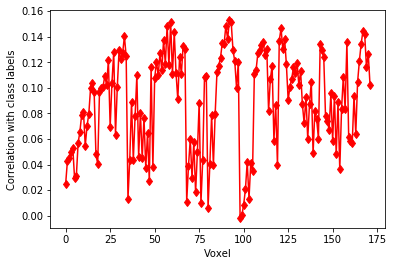

Number of significant voxels: 166 out of 172


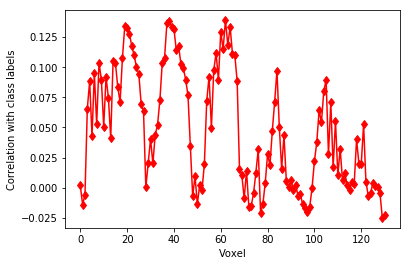

Number of significant voxels: 98 out of 131


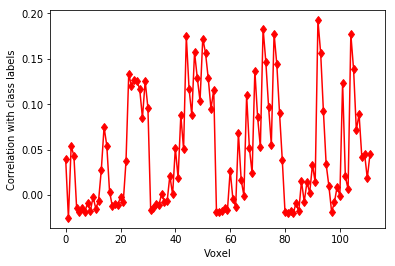

Number of significant voxels: 88 out of 112


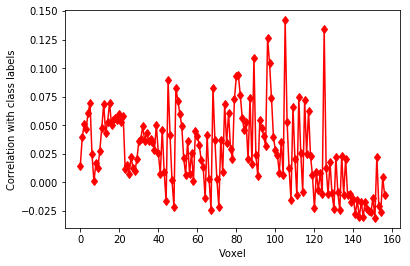

Number of significant voxels: 115 out of 157


In [29]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# A priori known number of voxels extracted from each subject for the LHPPA
num_voxels = [172, 131, 112, 157]
for n in num_voxels:
    sub_timeseries, sub_labels = zip(*[(arrx,np.repeat(np.array(arry)[np.newaxis,:], 5, axis=0)) for arrx,arry in zip(X['LHPPA'], Y['LHPPA']) if arrx.shape[1] == n])
    sub_timeseries = np.concatenate(sub_timeseries, axis=0)
    sub_labels = np.concatenate(sub_labels, axis = 0)
    sub_labels = np.array([np.nonzero(label)[0][0] + 1 for label in sub_labels])
    sub_labels[sub_labels == 4] = 0
    corr,p = zip(*[pearsonr(voxel,sub_labels) for voxel in sub_timeseries.T])
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    ax.plot(corr, color = 'r', marker = 'd')
    ax.set_xlabel('Voxel')
    ax.set_ylabel('Correlation with class labels')
    plt.show()
    sig = np.array(p) < 0.05
    print('Number of significant voxels: %d out of %d' % (np.count_nonzero(sig), sub_timeseries.shape[1]))

In [5]:
for mask in X.keys():
    last = 0
    print(mask)
    for sample in X[mask]:
        if sample.shape[1] != last:
            print('\t' + str(sample.shape))
        last = sample.shape[1]

LHPPA
	(5, 112)
	(5, 172)
	(5, 131)
	(5, 157)
RHLOC
	(5, 190)
	(5, 417)
	(5, 597)
	(5, 561)
LHLOC
	(5, 152)
	(5, 455)
	(5, 430)
	(5, 327)
RHEarlyVis
	(5, 696)
	(5, 241)
	(5, 285)
	(5, 356)
RHRSC
	(5, 116)
	(5, 143)
	(5, 142)
	(5, 278)
RHOPA
	(5, 205)
	(5, 95)
	(5, 187)
	(5, 335)
RHPPA
	(5, 161)
	(5, 198)
	(5, 200)
	(5, 187)
LHEarlyVis
	(5, 522)
	(5, 254)
	(5, 210)
	(5, 408)
LHRSC
	(5, 78)
	(5, 59)
	(5, 86)
	(5, 51)
LHOPA
	(5, 187)
	(5, 85)
	(5, 101)
	(5, 279)


We will take the top x most correlated voxels from each subject from each mask, where x is some number less than all the subjects' number of voxels for that specific mask, but not so low that we filter out all the voxels.

In [6]:
topvoxels = {'LHPPA': 100,
             'RHLOC': 170,
             'LHLOC': 130,
             'RHEarlyVis': 220,
             'RHRSC': 100,
             'LHOPA': 70,
             'RHPPA': 140,
             'LHEarlyVis': 190,
             'LHRSC': 30,
             'RHOPA': 80}

In [7]:
from scipy.stats import pearsonr

X_new = {}

for mask in X:
    # Get subject specific number of voxels to identify them
    last = 0
    num_voxels = []
    x = []
    for sample in X[mask]:
        if sample.shape[1] != last:
            num_voxels.append(sample.shape[1])
        last = sample.shape[1]
    for n in num_voxels:
        sub_timeseries, sub_labels = zip(*[(arrx,np.repeat(np.array(arry)[np.newaxis,:], 5, axis=0)) for arrx,arry in zip(X[mask], Y[mask]) if arrx.shape[1] == n])
        sub_timeseries2 = np.concatenate(sub_timeseries, axis=0)
        sub_labels = np.concatenate(sub_labels, axis = 0)
        sub_labels = np.array([np.nonzero(label)[0][0] + 1 for label in sub_labels])
        sub_labels[sub_labels == 4] = 0
        corr,p = zip(*[pearsonr(voxel,sub_labels) for voxel in sub_timeseries2.T])
        # Get indices of top x correlated voxels for this mask
        idx = np.argsort(np.abs(corr))[::-1][:topvoxels[mask]]
        x.append(np.array(sub_timeseries)[:,:,idx])
    x = np.concatenate(x,axis=0)
    X_new[mask] = x

Or, you could run PCA and see which voxels are most important in the high variance components.

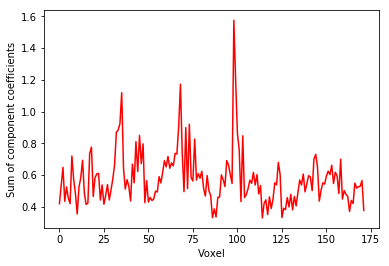

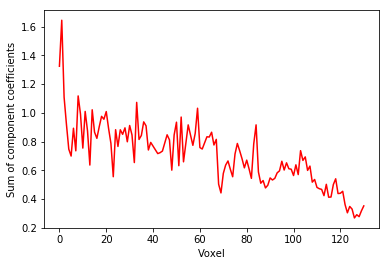

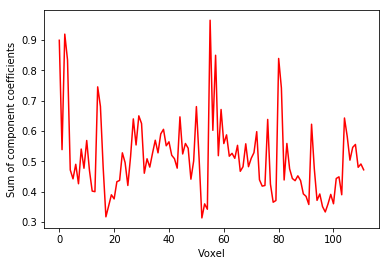

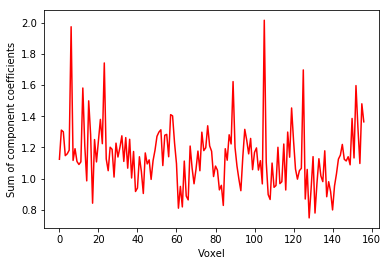

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# A priori known number of voxels extracted from each subject for the LHPPA
num_voxels = [172, 131, 112, 157]
for n in num_voxels:
    sub_timeseries = np.array([arrx for arrx in X['LHPPA'] if arrx.shape[1] == n])
    sub_activations = np.mean(sub_timeseries,axis=1)
    pca = PCA().fit(sub_activations)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    num_components = np.nonzero(explained_variance > 0.9)[0][0] + 1
    voxel_weights = np.sum(np.abs(pca.components_[:num_components]), axis = 0)
    plt.close('all')
    plt.plot(voxel_weights, color='r')
    plt.xlabel('Voxel')
    plt.ylabel('Sum of component coefficients')
    plt.show()

In [44]:
topvoxels = {'LHPPA': 100,
             'RHLOC': 170,
             'LHLOC': 130,
             'RHEarlyVis': 220,
             'RHRSC': 100,
             'LHOPA': 70,
             'RHPPA': 140,
             'LHEarlyVis': 190,
             'LHRSC': 30,
             'RHOPA': 80}

In [45]:
from sklearn.decomposition import PCA

X_new = {}

for mask in X:
    # Get subject specific number of voxels to identify them
    last = 0
    num_voxels = []
    x = []
    for sample in X[mask]:
        if sample.shape[1] != last:
            num_voxels.append(sample.shape[1])
        last = sample.shape[1]
    for n in num_voxels:
        sub_timeseries = np.array([arrx for arrx in X[mask] if arrx.shape[1] == n])
        sub_activations = np.mean(sub_timeseries,axis=1)
        pca = PCA().fit(sub_activations)
        explained_variance = np.cumsum(pca.explained_variance_ratio_)
        num_components = np.nonzero(explained_variance > 0.9)[0][0] + 1
        voxel_weights = np.sum(np.abs(pca.components_[:num_components]), axis = 0)
        idx = np.argsort(voxel_weights)[::-1][:topvoxels[mask]]
        x.append(np.array(sub_timeseries)[:,:,idx])
    x = np.concatenate(x,axis=0)
    X_new[mask] = x

### Save finalized fixed data

Ok, finally made it to cleaned data, ready to train on!

In [46]:
for mask in Y:
    Y[mask] = np.array(Y[mask])
    Ynames[mask] = np.array(Ynames[mask])
    
    print(mask + ': shape of X is ' + str(X_new[mask].shape))
    print(mask + ': shape of Y is ' + str(Ynames[mask].shape))
    
    np.save(data_dir + 'X_' + mask + '.npy', X_new[mask])
    np.save(data_dir + 'Y_' + mask + '.npy', Y[mask])
    np.save(data_dir + 'Ylabels_' + mask + '.npy', Ynames[mask])

LHPPA: shape of X is (19380, 5, 100)
LHPPA: shape of Y is (19380,)
RHLOC: shape of X is (19380, 5, 170)
RHLOC: shape of Y is (19380,)
LHLOC: shape of X is (19380, 5, 130)
LHLOC: shape of Y is (19380,)
RHEarlyVis: shape of X is (19380, 5, 220)
RHEarlyVis: shape of Y is (19380,)
RHRSC: shape of X is (19380, 5, 100)
RHRSC: shape of Y is (19380,)
RHOPA: shape of X is (19380, 5, 80)
RHOPA: shape of Y is (19380,)
RHPPA: shape of X is (19380, 5, 140)
RHPPA: shape of Y is (19380,)
LHEarlyVis: shape of X is (19380, 5, 190)
LHEarlyVis: shape of Y is (19380,)
LHRSC: shape of X is (19380, 5, 30)
LHRSC: shape of Y is (19380,)
LHOPA: shape of X is (19380, 5, 70)
LHOPA: shape of Y is (19380,)


In [47]:
import pickle

with open(data_dir + 'X_fixed.p', 'w') as f:
    pickle.dump(X_new, f)
    
with open(data_dir + 'Y_fixed.p', 'w') as f:
    pickle.dump(Y, f)
    
with open(data_dir + 'Ylabels_fixed.p', 'w') as f:
    pickle.dump(Ynames, f)